In [159]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
from keras.utils import to_categorical

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
import sklearn.linear_model
from time import time

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [261]:
class NeuralNet:
    
    
    def __init__(self, normalize = False, learning_rate = 0.01, max_iter = 100,\
                 hidden_layer_sizes=(100,), beta=0.999, epsilon=1e-8, tol=1e-6, batch_size=2048,\
                 print_cost=True):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.epsilon = epsilon
        self.tol = tol
        self.beta = beta
        self.batch_size = batch_size
        self.print_cost = print_cost
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        W = list()
        b = list()
        self.S_dW = list()
        self.S_db = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) / np.sqrt(
                hidden_layers[i - 1]))
            b.append(np.zeros((hidden_layers[i], 1)))
            
            self.S_dW.append(np.zeros((hidden_layers[i], hidden_layers[i-1])))
            self.S_db.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}
    
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
               
        for i in range(0, self.n_layers-1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    def cross_entropy(self, A, Y):
        return - np.sum(np.log(A) * (Y), axis=1)
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.n_layers-1, 0, -1):
            dZ[i-1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True) 
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            self.S_dW[i] = self.beta * self.S_dW[i] + (1 - self.beta) * np.power(dW[i], 2)
            self.S_db[i] = self.beta * self.S_db[i] + (1 - self.beta) * np.power(db[i], 2)
            W[i] = W[i] - self.learning_rate * dW[i] / (np.sqrt(self.S_dW[i]) + self.epsilon)
            b[i] = b[i] - self.learning_rate * db[i] / (np.sqrt(self.S_db[i]) + self.epsilon)
            
        self.parameters = {"W" : W, "b" : b}
        
    def create_mini_batches(self, X, Y, batch_size): 
        m = X.shape[1]
        mini_batches = [] 
        
        batch_size = self.batch_size if self.batch_size != None else m
        
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        
        shuffled_Y = Y[:, permutation]
         
        n_minibatches = m // batch_size 

        for i in range(n_minibatches + 1): 
            X_mini = shuffled_X[:, i*batch_size : (i + 1)*batch_size]
            Y_mini = shuffled_Y[:, i*batch_size : (i + 1)*batch_size] 
            mini_batches.append((X_mini, Y_mini)) 
        if m % batch_size != 0: 
            X_mini = shuffled_X[:, i*batch_size:]
            Y_mini = shuffled_Y[:, i*batch_size:]
            mini_batches.append((X_mini, Y_mini)) 
        return mini_batches 

    def fit(self, X_vert, Y_vert):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        cost_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)

        
        
        for i in range(self.max_iter):
            self.n_iter = i
            
            mini_batches = self.create_mini_batches(X, Y, self.batch_size)
            
            for (mini_X, mini_Y) in mini_batches:
                A, cache = self.__forward_propagation(mini_X)

                cost = self.compute_cost(A, mini_Y)

                grads = self.__backward_propagation(mini_X, mini_Y, cache)

                self.__update_parameters(grads)
            
            cost_history.append(cost)
            
            if self.print_cost and i % 10 == 0:
                print("{}-th iteration: {}".format(i, cost))

            #if i % 10 == 0:
            costs.append(cost)
  
            if i > 1 and abs(cost-cost_history[-2]) < self.tol:
                break

        if self.print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.to_classlabel(positive_probs)
        return y_pred  

    def to_classlabel(self, z):
        return z.argmax(axis=1)
    
    def score(self, X, y, sample_weight=None):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        return accuracy
        

# Getting data

In [161]:
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
df.shape

(42000, 785)

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [164]:
df.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [165]:
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [166]:
y = df["label"]
X = df.drop('label', axis = 1)

In [167]:
X.shape

(42000, 784)

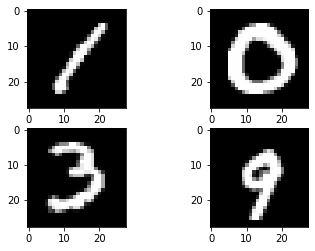

In [168]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(X.iloc[0].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
axs[0, 1].imshow(X.iloc[4].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
axs[1, 0].imshow(X.iloc[9].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
axs[1, 1].imshow(X.iloc[28].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

# Correlation between features, features and target

### It will be hard to see correlation between features, tagret using pairplot or heatmap because it's set of pixels. So, we will take 10 different digits and their middle pixels. Pixels between 336 and 419 and we will take a look at difference

In [169]:
df.head(25)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
# id-target 0-1, 1-0, 3-4, 6-7, 7-3, 8-5, 10-8, 11-9, 16-2, 21-6 

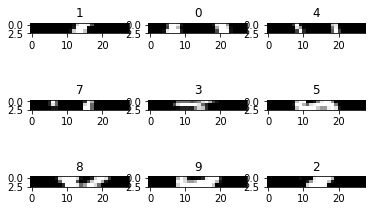

In [171]:
fig, axs = plt.subplots(3, 3)
axs[0, 0].imshow(X.loc[0, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))
axs[0, 1].imshow(X.loc[1, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))
axs[0, 2].imshow(X.loc[3, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))

axs[1, 0].imshow(X.loc[6, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))
axs[1, 1].imshow(X.loc[7, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))
axs[1, 2].imshow(X.loc[8, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))

axs[2, 0].imshow(X.loc[10, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))
axs[2, 1].imshow(X.loc[11, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))
axs[2, 2].imshow(X.loc[16, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))

axs[0, 0].title.set_text('1')
axs[0, 1].title.set_text('0')
axs[0, 2].title.set_text('4')

axs[1, 0].title.set_text('7')
axs[1, 1].title.set_text('3')
axs[1, 2].title.set_text('5')

axs[2, 0].title.set_text('8')
axs[2, 1].title.set_text('9')
axs[2, 2].title.set_text('2')

plt.show()

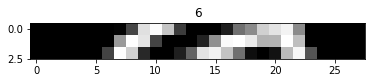

In [172]:
plt.imshow(X.loc[21, 'pixel336':'pixel419'].values.reshape(3, 28), cmap=plt.get_cmap('gray'))
plt.title('6')
plt.show()

#### Target 1 and 0. Where target 1 we can see one vertical line of non-zero pixels in the middle of picture at the same time target 0 has two vertical line of non-zero pixels around the edges. 0 similar to 4 but the difference 0 has more rounded lines and 4 more straight. Looks the same 1 and 2, 8 and 9 on this scale

# Split into train and test sets

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [174]:
df.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

### No missing values 

### Normalization

In [175]:
# use this type of normalization because it scales features between 0 and 1 and no need use another
class Normalize(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = 255
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X / self.scaler
        return X
        

In [176]:
nr = Normalize()

In [177]:
t = nr.fit_transform(X_train)

In [178]:
t.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,33600.0,...,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.0,33600.0,33600.0,33600.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000936,0.000519,0.000245,0.000090,0.000067,0.000014,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026135,0.019399,0.013004,0.007590,0.007625,0.001816,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.996078,0.996078,0.988235,0.992157,0.996078,0.243137,0.0,0.0,0.0,0.0


## Creating Pipeline

In [226]:
numeric_features = list(X.columns) 
numeric_transformer = Pipeline([('normalize', Normalize())])

## Creating ColumnTransformer 

In [180]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Test with sklearn MLPClassifier

In [181]:
from sklearn.neural_network import MLPClassifier

# Create Pipeline using Transformation pipeline

In [182]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MLPClassifier())])

In [183]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('normalize',
                                                                   Normalize())],
                                                           verbose=False),
                                                  ['pixel0', 'pixel1', 'pixel2',
                                                   'pixel3', 'pixel4', 'pixel5',
                                                   'pixel6', 'pixel7', 'pixel8',
                                                   'pixel9', 'pixel10',
                                                   'pixel11', 'pixel12',
       

In [185]:
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.976


In [186]:
y_test_pred = clf.predict(X_test)

In [187]:
res = pd.DataFrame({'y_actual' : y_test, 'y_pred' : y_test_pred})
print(res)

       y_actual  y_pred
27084         7       7
18640         3       3
41477         9       9
39744         8       8
28354         6       6
...         ...     ...
37833         1       1
21903         4       4
33499         6       6
36169         4       4
16109         1       1

[8400 rows x 2 columns]


In [192]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [199]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label='positive', average='weighted')
recall = recall_score(y_test, y_test_pred, pos_label='positive', average='weighted')

# Results for test

In [198]:
print('Custom Logistic Regression (Test)')
print('Accuracy       : ', accuracy)
print('Precision      : ', precision)
print('Recall         : ', recall)

Custom Logistic Regression (Test)
Accuracy       :  0.9761904761904762
Precision      :  0.976175738325087
Recall         :  0.9761904761904762


In [200]:
y_train_pred = clf.predict(X_train)

In [201]:
accuracy_tr = accuracy_score(y_train, y_train_pred)
precision_tr = precision_score(y_train, y_train_pred, pos_label='positive', average='weighted')
recall_tr = recall_score(y_train, y_train_pred, pos_label='positive', average='weighted')

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


# Result for train

In [202]:
print('Custom Logistic Regression (Train)')
print('Accuracy       : ', accuracy_tr)
print('Precision      : ', precision_tr)
print('Recall         : ', recall_tr)

Custom Logistic Regression (Train)
Accuracy       :  1.0
Precision      :  1.0
Recall         :  1.0


# Hyperparameter GridSearchCV

In [204]:
from sklearn.model_selection import GridSearchCV

In [221]:
param_grid = {
    'classifier__solver': ['adam'],
    'classifier__max_iter': [100,500,1000 ],
    'classifier__learning_rate_init': [0.5, 0.1, 0.01],
    'classifier__hidden_layer_sizes': [(100,), (50,), (100, 50,)],
    'classifier__random_state': [42]
}

search = GridSearchCV(clf, param_grid, n_jobs=-1)

In [222]:
t0 = time()
search.fit(X_train, y_train)
print("done in %fs" % (time() - t0))

done in 2184.220809s


In [223]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.966):
{'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 100, 'classifier__random_state': 42, 'classifier__solver': 'adam'}


In [225]:
accuracy_score(y_test, search.predict(X_test))

0.9677380952380953

# Test with custom NeuralNetwork

In [234]:
encoder = OneHotEncoder()

y_train_e = encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_train_e.shape

(33600, 10)

# Create Pipeline using Transformation pipeline

In [262]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', NeuralNet())])

0-th iteration: 0.0829200805901644
10-th iteration: 0.011854125556137945
20-th iteration: 0.007465627592633321
30-th iteration: 0.008567239158232352
40-th iteration: 0.004184799633669686
50-th iteration: 0.0062146880573081585
60-th iteration: 0.0023691058327074918
70-th iteration: 0.0025240840450007312
80-th iteration: 0.0029735177498223953
90-th iteration: 0.0024793799663636205


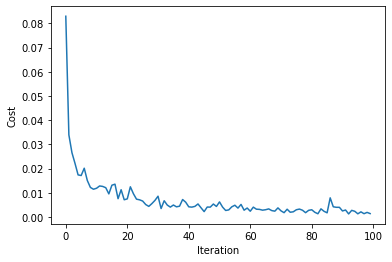

done in 171.310719s


In [263]:
t0 = time()
clf.fit(X_train, y_train_e)
print("done in %fs" % (time() - t0))

In [264]:
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.950


In [265]:
y_test_pred = clf.predict(X_test)

In [266]:
res = pd.DataFrame({'y_actual' : y_test, 'y_pred' : y_test_pred})
print(res)

       y_actual  y_pred
27084         7       7
18640         3       3
41477         9       9
39744         8       8
28354         6       6
...         ...     ...
37833         1       1
21903         4       4
33499         6       6
36169         4       4
16109         1       1

[8400 rows x 2 columns]


In [267]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label='positive', average='weighted')
recall = recall_score(y_test, y_test_pred, pos_label='positive', average='weighted')

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


# Result for test

In [268]:
print('Custom Logistic Regression (Test)')
print('Accuracy       : ', accuracy)
print('Precision      : ', precision)
print('Recall         : ', recall)

Custom Logistic Regression (Test)
Accuracy       :  0.9497619047619048
Precision      :  0.949836385688267
Recall         :  0.9497619047619048


In [269]:
y_train_pred = clf.predict(X_train)

In [270]:
accuracy_tr = accuracy_score(y_train, y_train_pred)
precision_tr = precision_score(y_train, y_train_pred, pos_label='positive', average='weighted')
recall_tr = recall_score(y_train, y_train_pred, pos_label='positive', average='weighted')

# Result for train

In [271]:
print('Custom Logistic Regression (Train)')
print('Accuracy       : ', accuracy_tr)
print('Precision      : ', precision_tr)
print('Recall         : ', recall_tr)

Custom Logistic Regression (Train)
Accuracy       :  0.9955952380952381
Precision      :  0.9955968392748477
Recall         :  0.9955952380952381
